In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#Step 1: Data Extraction and Loading

#Extract Data: Load the necessary tables from the Ergast dataset, which includes drivers, constructors, races, qualifying, results, driverStandings, and constructorStandings.
#Load Data: Use a database client (e.g., MySQL, SQLite) or CSV files to load the data into a pandas DataFrame.
# Load data
constructors_df = pd.read_csv("f1db_csv/constructors.csv")
races_df=pd.read_csv("f1db_csv/races.csv")
quali_df=pd.read_csv("f1db_csv/qualifying.csv")
results_df=pd.read_csv("f1db_csv/results.csv")
driverStandings_df=pd.read_csv("f1db_csv/driver_standings.csv")
constructorStandings_df=pd.read_csv("f1db_csv/constructor_standings.csv")
drivers_df = pd.read_csv('f1db_csv/drivers.csv')

#Step 2: Data Preprocessing

#Merge Tables:
#Merge results with races to get race-specific details.
#Merge the combined DataFrame with qualifying to get qualifying positions.
#Merge with driverStandings and constructorStandings to include standings.
#Merge with drivers and constructors to add driver and constructor details.

# Merge data
data = results_df.merge(races_df, on="raceId")
data1 = data.merge(quali_df, on=["raceId","driverId","constructorId"], how="left")
data2 = data1.merge(driverStandings_df, on=["raceId","driverId"], how="left")
data3 = data2.merge(constructorStandings_df, on=['raceId','constructorId'])
data4 = data3.merge(drivers_df, on=['driverId'], how='left')
data5 = data4.merge(constructors_df, on=['constructorId'], how='left')

In [2]:
#Handle Missing Values:
#Fill or drop missing values as appropriate for the analysis.
#Common strategies include filling with mean/median/mode or dropping rows with missing critical values.
#Convert Data Types:
#Ensure all columns are in the appropriate data type (e.g., integers for IDs, floats for numerical values).

columns=data5.columns

data5.replace('\\N', np.nan, inplace=True)
total_n_values = (data5.applymap(lambda x: x == '\\N')).sum().sum()
print(total_n_values)

data5.to_csv('output.csv', index=False)
f1data=pd.read_csv("output.csv", low_memory=False, index_col=False)
f1data.drop(['drivers_url','const_url'], axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_3996\504534400.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  total_n_values = (data5.applymap(lambda x: x == '\\N')).sum().sum()


0


In [3]:
#Step 3: Feature Engineering

#Create New Features:
#Qualifying Position: Use the qualifying position as a feature.
#Previous Race Results: Calculate the average finishing position of the driver and constructor in previous races.
#Circuit Characteristics: Extract features such as circuit length, number of turns, and altitude.
#Weather Conditions: If available, include weather conditions like temperature, rain probability, etc.
#Driver and Constructor Standings: Use the current standings points and positions.
#Normalize/Standardize Features: Scale numerical features to ensure they have a mean of 0 and standard deviation of 1 (standardization) or scale between 0 and 1 (normalization).

# Feature engineering
f1data['average_finish'] = f1data.groupby('driverId')['results_positionOrder'].transform('mean')
f1data['date']=pd.to_datetime(f1data['races_date']).apply(lambda x: x.year)
f1data['age'] = f1data['date'] - pd.to_datetime(f1data['drivers_dob']).dt.year
f1data['experience'] = f1data['year'] - f1data.groupby('driverId')['year'].transform('min')
f1data['average_lap_time'] = f1data.groupby(['raceId', 'driverId'])['results_milliseconds'].transform('mean')

# Select features and target
features = ['age','experience','results_grid','quali_position','average_lap_time','average_finish','driver_standings_points','driver_standings_position','const_standing_points','const_standing_position']
target = 'results_positionOrder'
X = f1data[features]
y = f1data[target]

# Handling missing values
X.fillna(X.mean(), inplace=True)

# Encoding categorical variables
X = pd.get_dummies(X)

C:\Users\HP\AppData\Local\Temp\ipykernel_3996\749425323.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [4]:
f1data_filtered = f1data[f1data['date'] >= 2004]
f1data_filtered = f1data_filtered.sort_values(by='date', ascending=True)
f1data_filtered.head()

,resultId,raceId,driverId,constructorId,results_number,results_grid,results_position,results_positionText,results_positionOrder,results_points,...,drivers_dob,drivers_nationality,constructorRef,const_name,const_nationality,average_finish,date,age,experience,average_lap_time
1590,1601,94,21,15,11.0,12,7.0,7,7,2.0,...,1973-01-14,Italian,sauber,Sauber,Swiss,10.880531,2004,31,8,5329949.0
1618,1627,95,8,1,6.0,5,NaN,R,13,0.0,...,1979-10-17,Finnish,mclaren,McLaren,British,8.491477,2004,25,3,NaN
1619,1632,95,14,1,5.0,8,NaN,R,18,0.0,...,1971-03-27,British,mclaren,McLaren,British,9.386831,2004,33,10,NaN
1620,1630,95,17,19,14.0,11,NaN,R,16,0.0,...,1976-08-27,Australian,jaguar,Jaguar,British,9.691589,2004,28,2,NaN
1621,1634,95,32,19,15.0,14,NaN,R,20,0.0,...,1983-02-07,Austrian,jaguar,Jaguar,British,13.666667,2004,21,0,NaN


In [5]:
f1data_filtered.isna().sum()

resultId               0
raceId                 0
driverId               0
constructorId          0
results_number         0
                    ... 
average_finish         0
date                   0
age                    0
experience             0
average_lap_time    4223
Length: 66, dtype: int64

In [6]:
scaler=MinMaxScaler()
scaler.fit(X)
scaled_data=scaler.transform(X)

In [7]:
scaled_data

array([[0.12195122, 0.04347826, 0.03125   , ..., 0.        , 0.01627907,
        0.        ],
       [0.2195122 , 0.04347826, 0.09375   , ..., 0.04878049, 0.01627907,
        0.        ],
       [0.31707317, 0.34782609, 0.15625   , ..., 0.01219512, 0.00930233,
        0.1       ],
       ...,
       [0.14634146, 0.13043478, 0.53125   , ..., 0.1097561 , 0.03255814,
        0.25      ],
       [0.24390244, 0.2173913 , 0.        , ..., 0.19512195, 0.00232558,
        0.4       ],
       [0.14634146, 0.04347826, 0.59375   , ..., 0.24390244, 0.00232558,
        0.4       ]])

In [8]:
column_types = f1data.dtypes

# Filter columns with 'object' type (string columns)
string_columns = column_types[column_types == 'object'].index.tolist()

In [9]:
len(string_columns)

31

In [10]:
from pycaret.classification import *

setup(data=f1data_filtered, 
      target=target, 
      numeric_features=features, 
      ignore_features=string_columns)

,Description,Value
0,Session id,1663
1,Target,results_positionOrder
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23"
4,Original data shape,"(8350, 66)"
5,Transformed data shape,"(8350, 35)"
6,Transformed train set shape,"(5845, 35)"
7,Transformed test set shape,"(2505, 35)"
8,Ignore features,31
9,Numeric features,10


In [11]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8616,0.9902,0.8616,0.8739,0.8647,0.8549,0.8553,4.0580
xgboost,Extreme Gradient Boosting,0.8614,0.9902,0.8614,0.8705,0.8635,0.8547,0.8550,1.8850
catboost,CatBoost Classifier,0.8602,0.9889,0.8602,0.8726,0.8637,0.8535,0.8538,126.7690
dt,Decision Tree Classifier,0.8565,0.9252,0.8565,0.8578,0.8556,0.8496,0.8497,0.1050
rf,Random Forest Classifier,0.8036,0.9783,0.8036,0.8087,0.8037,0.7941,0.7944,0.9600
dummy,Dummy Classifier,0.0470,0.5000,0.0470,0.0022,0.0042,0.0000,0.0000,0.0580


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1663, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [12]:
lgbm_model=create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8701,0.9906,0.8701,0.8835,0.8742,0.8638,0.8641
1,0.8479,0.9880,0.8479,0.8571,0.8507,0.8405,0.8409
2,0.8889,0.9929,0.8889,0.8903,0.8885,0.8835,0.8837
3,0.8444,0.9890,0.8444,0.8579,0.8490,0.8370,0.8372
4,0.8547,0.9889,0.8547,0.8766,0.8606,0.8477,0.8482
5,0.8733,0.9912,0.8733,0.8876,0.8778,0.8671,0.8676
6,0.8339,0.9878,0.8339,0.8512,0.8396,0.8258,0.8264
7,0.8699,0.9913,0.8699,0.8837,0.8732,0.8635,0.8639
8,0.8750,0.9912,0.8750,0.8888,0.8757,0.8689,0.8697


In [ ]:
evaluate_model(lgbm_model)

In [14]:
prediction_df=predict_model(lgbm_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8567,0.9899,0.8567,0.8684,0.8610,0.8498,0.8500


In [15]:
new_predictions=predict_model(lgbm_model, f1data_filtered)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9570,0.9990,0.9570,0.9584,0.9575,0.9549,0.9550


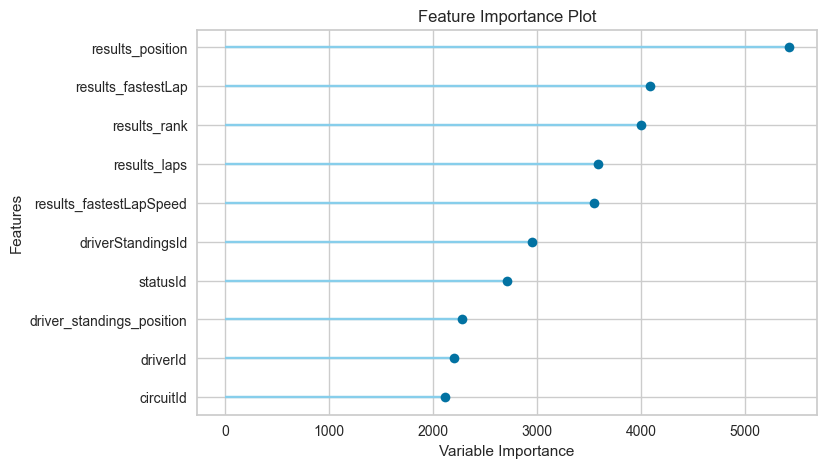

In [16]:
plot_model(lgbm_model, plot='feature')

In [17]:
new_predictions.head()

,resultId,raceId,driverId,constructorId,results_number,results_grid,results_position,results_positionText,results_points,results_laps,...,const_name,const_nationality,average_finish,date,age,experience,average_lap_time,results_positionOrder,prediction_label,prediction_score
1590,1601,94,21,15,11.0,12,7.0,7,2.0,66,...,Sauber,Swiss,10.880531,2004,31,8,5329949.0,7,7,1.0000
1618,1627,95,8,1,6.0,5,NaN,R,0.0,27,...,McLaren,British,8.491477,2004,25,3,NaN,13,13,0.9996
1619,1632,95,14,1,5.0,8,NaN,R,0.0,2,...,McLaren,British,9.386831,2004,33,10,NaN,18,18,0.9943
1620,1630,95,17,19,14.0,11,NaN,R,0.0,11,...,Jaguar,British,9.691588,2004,28,2,NaN,16,16,0.9992
1621,1634,95,32,19,15.0,14,NaN,R,0.0,0,...,Jaguar,British,13.666667,2004,21,0,NaN,20,17,0.6609


In [18]:
newf1=f1data_filtered.drop(columns=string_columns)
newf1_filtered=newf1.drop(columns='results_positionOrder')


In [19]:
len(newf1_filtered.columns)

34

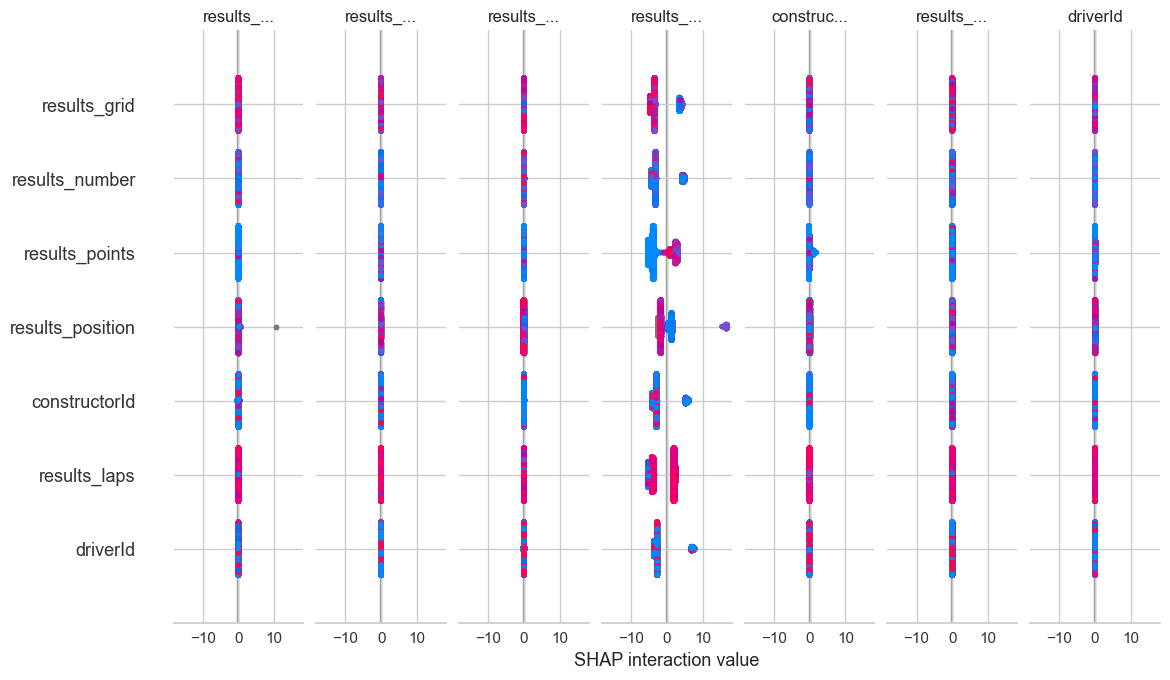

In [23]:
#Interpret the model


import shap

# Assuming your model is named 'best_model'
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(newf1_filtered)

# Plot feature importance
shap.summary_plot(shap_values, newf1_filtered)

In [24]:
from pycaret.classification import tune_model

tuned_model = tune_model(lgbm_model)
print(tuned_model)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8581,0.9905,0.8581,0.8651,0.8601,0.8513,0.8516
1,0.8513,0.9888,0.8513,0.8627,0.8554,0.8442,0.8444
2,0.8872,0.9932,0.8872,0.8924,0.8887,0.8817,0.8819
3,0.8564,0.9889,0.8564,0.8733,0.8619,0.8496,0.8500
4,0.8615,0.9903,0.8615,0.8730,0.8648,0.8550,0.8553
5,0.8664,0.9914,0.8664,0.8779,0.8694,0.8600,0.8604
6,0.8425,0.9884,0.8425,0.8650,0.8488,0.8349,0.8356
7,0.8630,0.9913,0.8630,0.8693,0.8651,0.8564,0.8565
8,0.8682,0.9917,0.8682,0.8691,0.8675,0.8618,0.8619


Fitting 10 folds for each of 10 candidates, totalling 100 fits
LGBMClassifier(bagging_fraction=0.7, bagging_freq=5, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=66, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=60, n_jobs=-1, num_leaves=200, objective=None,
               random_state=1663, reg_alpha=2, reg_lambda=0.7, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


In [25]:
import joblib

# Save the model
joblib.dump(tuned_model, 'lgbm_model.pkl')

# Load the model
loaded_model = joblib.load('lgbm_model.pkl')